<a href="https://colab.research.google.com/github/hanhanwu/Hanhan_LangGraph_Exercise/blob/main/AI_for_BI/sql_agent_with_validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SQL Agent with SQL Validation

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_openai langchain_community

In [2]:
from google.colab import userdata

# load the environment variables set in colab
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

# About the Data

In [3]:
import requests

url = "https://storage.googleapis.com/benchmarks-artifacts/chinook/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    # Open a local file in binary write mode
    with open("Chinook.db", "wb") as file:
        # Write the content of the response (the file) to the local file
        file.write(response.content)
    print("File downloaded and saved as Chinook.db")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

File downloaded and saved as Chinook.db


In [4]:
from langchain_community.utilities import SQLDatabase
import pandas as pd
import pprint
import json
import ast


db = SQLDatabase.from_uri("sqlite:///Chinook.db")  # load the downloaded DB
print(db.dialect)
all_table_names = db.get_usable_table_names()
print('All the Usable Tables:', all_table_names)
print()

table = 'Track'
print(f'Data Sample from Table {table}:')
sample = ast.literal_eval(db.run(f"SELECT * FROM {table} LIMIT 5;"))
columns_query = f"""SELECT name FROM pragma_table_info('{table}')"""
cols = db.run(columns_query)
sample_df = pd.DataFrame(sample, columns=[col[0] for col in ast.literal_eval(cols)])
display(sample_df)

sqlite
All the Usable Tables: ['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']

Data Sample from Table Track:


,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


In [5]:
all_table_schemas = {}
schema_cols = ['cid', 'name', 'type', 'notnull', 'default_value', 'pk']
for table_name in all_table_names:
    # Get schema data
    schema_query = f"PRAGMA table_info({table_name});"
    schema_result = db.run(schema_query)
    schema_data = ast.literal_eval(schema_result)

    # Combine column names and schema data
    schema = []
    for i, data in enumerate(schema_data):
        schema.append(dict(zip(schema_cols, data)))
    all_table_schemas[table_name] = schema

for k, v in all_table_schemas.items():
  print(k)
  print(v)
  break

Album
[{'cid': 0, 'name': 'AlbumId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 1}, {'cid': 1, 'name': 'Title', 'type': 'NVARCHAR(160)', 'notnull': 1, 'default_value': None, 'pk': 0}, {'cid': 2, 'name': 'ArtistId', 'type': 'INTEGER', 'notnull': 1, 'default_value': None, 'pk': 0}]


# Build Agent

### The State of Agent

In [11]:
from typing import List
from typing import Annotated, Sequence, Literal
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    success_execution: bool
    rewrite_ct: int
    valid_sql: bool

### Nodes & Edges

In [9]:
import re
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import tools_condition


openai_model_str = "gpt-4o-mini-2024-07-18"
REWRITE_LIMIT  = 3

In [22]:
def extract_sql_str(raw_str):
  pattern = r"""```sql\n(.*?)\n```"""
  match = re.search(pattern, raw_str, re.DOTALL)  # re.DOTALL allows matching across lines.

  if match:
    return match.group(1).strip()  # Extract and clean the content.
  else:
    return None


def write_sql(state):
  """
    Given user's question,
      1. LLM to check whether there's available table, if not generate the answer directly.
      2. Otherwise, write the SQL query to answer user's question.
  """
  print("---WRITE SQL---")
  msgs = state["messages"]
  user_question = msgs[0].content

  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=openai_model_str, streaming=True)
  prompt = [
      SystemMessage(content="You are a SQL expert able to write SQL queries to answer user's questions."),
      HumanMessage(
          content=f""" \n
                  Given every table's schema in the database: {all_table_schemas} \n
                  and here's user's question: {user_question} \n
                  if there's no available table to answer the user question, output 'No table found' \n
                  otherwise, output the SQL query to answer user's question: """,
      )
  ]
  result = model.invoke(prompt).content
  if 'No table found' in result:
    output = 'No table found'
  else:
    output = extract_sql_str(result)

  return {"messages": [output], "rewrite_ct": 0}


def validate_sql(state) -> Literal["write_sql", "execute_sql"]:
  """
    Validate the generated SQL query.
  """
  print("---VALIDATE SQL---")
  msgs = state["messages"]
  generated_sql = msgs[-1].content
  user_question = msgs[0].content

  class grade(BaseModel):
        """Binary score for SQL validation."""
        binary_score: str = Field(description="SQL validation score 'yes' or 'no'")

  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=openai_model_str, streaming=True)
  llm_with_tool = model.with_structured_output(grade)
  prompt = [
      SystemMessage(content="You are a SQL expert able to write SQL queries to answer user's questions."),
      HumanMessage(
          content=f""" \n
                  Given every table's schema in the database: {all_table_schemas} \n
                  and here's user's question: {user_question}. \n
                  Does generated SQL {generated_sql} answers user's question?
                  If so, output 'yes', otherwise output 'no' """,
      )
  ]
  validation_result = llm_with_tool.invoke(prompt).binary_score

  if validation_result == "yes":
      return {"valid_sql": True}
  elif validation_result == "no":
      return {"valid_sql": False}
  else:
      raise ValueError(f"Invalid validation result: {validation_result}")


def execute_sql(state):
  """
    Execute the generated SQL query.
  """
  print("---EXECUTE SQL---")
  generated_sql = state["messages"][-1].content

  try:
    result = db.run(generated_sql)
    return {"messages": [result],
            "success_execution": True}
  except:
    print('SQL Execution Error')
    return {"messages": [generated_sql],
            "success_execution": False}


def rewrite_sql(state):
  """
    Rewrite the generated SQL query.
  """
  rewrite_ct = state["rewrite_ct"] + 1
  if rewrite_ct >= REWRITE_LIMIT:
    return {"messages": ["Can't find the answer"], "rewrite_ct": rewrite_ct}

  print("---REWRITE SQL---")
  msgs = state["messages"]
  error_sql = msgs[-1].content
  user_question = msgs[0].content

  model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY,
                       model=openai_model_str, streaming=True)

  prompt = [
      SystemMessage(content="You are a SQL expert able to write SQL queries to answer user's questions."),
      HumanMessage(
          content=f""" \n
                  Given every table's schema in the database: {all_table_schemas} \n
                  and here's user's question: {user_question}. \n
                  Previously written SQL {error_sql} got execution error \n
                  please find another way to write the SQL query to answer user's question: """,
      )
  ]
  rewritten_sql = extract_sql_str(model.invoke(prompt).content)

  return {"messages": [rewritten_sql], "rewrite_ct": rewrite_ct}


def output_answer(state):
  """
    Output the final results
  """
  print("---OUTPUT ANSWER---")
  msgs = state["messages"]
  final_output = msgs[-1].content

  return {"messages": [final_output]}

### Build Graph

In [23]:
from langgraph.graph import END, StateGraph, START

# define a new graph
workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("write_sql", write_sql)
workflow.add_node("validate_sql",validate_sql)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("rewrite_sql", rewrite_sql)
workflow.add_node("output_answer", output_answer)

# add edges
workflow.add_edge(START, "write_sql")
workflow.add_conditional_edges(
    "write_sql",
    lambda state: "No table found" not in state["messages"][-1].content,
    {False: "output_answer", True: "validate_sql"}
)
workflow.add_conditional_edges(
    "validate_sql",
    lambda state: state["valid_sql"],
    {False: "write_sql", True: "execute_sql"}
)
workflow.add_conditional_edges(
    "execute_sql",
    lambda state: state["success_execution"],
    {False: "rewrite_sql", True: "output_answer"}
)
workflow.add_conditional_edges(
    "rewrite_sql",
    lambda state: state["rewrite_ct"] <= REWRITE_LIMIT,
    {False: "output_answer", True: "validate_sql"}
)
workflow.add_edge("output_answer", END)

# compile
graph = workflow.compile()


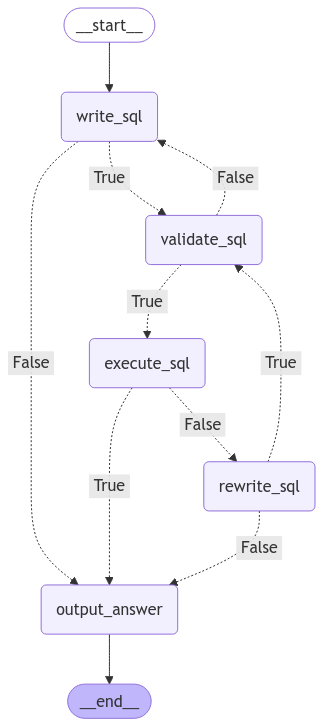

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Run SQL Agent

In [25]:
import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.errors import GraphRecursionError


def run_graph(inputs):
  for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

In [26]:
inputs = {
    "messages": [
        ("user", """Find me the unique number of customers and artists,
                    output as a table with column names?"""),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{ 'messages': [ 'SELECT \n'
                "    'Customers' AS Category, \n"
                '    COUNT(DISTINCT CustomerId) AS UniqueCount \n'
                'FROM \n'
                '    Customer\n'
                'UNION ALL\n'
                'SELECT \n'
                "    'Artists' AS Category, \n"
                '    COUNT(DISTINCT ArtistId) AS UniqueCount \n'
                'FROM \n'
                '    Artist;'],
  'rewrite_ct': 0}

---VALIDATE SQL---
"Output from node 'validate_sql':"
{'valid_sql': True}

---EXECUTE SQL---
"Output from node 'execute_sql':"
{ 'messages': ["[('Customers', 59), ('Artists', 275)]"],
  'success_execution': True}

---OUTPUT ANSWER---
"Output from node 'output_answer':"
{'messages': ["[('Customers', 59), ('Artists', 275)]"]}



In [28]:
inputs = {
    "messages": [
        ("user", """Find top 3 customers who bought most amount of album,
         list their names and the amount of album they bought"""),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{ 'messages': [ 'SELECT \n'
                "    c.FirstName || ' ' || c.LastName AS CustomerName,\n"
                '    COUNT(DISTINCT t.AlbumId) AS AlbumCount\n'
                'FROM \n'
                '    Customer c\n'
                'JOIN \n'
                '    Invoice i ON c.CustomerId = i.CustomerId\n'
                'JOIN \n'
                '    InvoiceLine il ON i.InvoiceId = il.InvoiceId\n'
                'JOIN \n'
                '    Track t ON il.TrackId = t.TrackId\n'
                'GROUP BY \n'
                '    c.CustomerId\n'
                'ORDER BY \n'
                '    AlbumCount DESC\n'
                'LIMIT 3;'],
  'rewrite_ct': 0}

---VALIDATE SQL---
"Output from node 'validate_sql':"
{'valid_sql': True}

---EXECUTE SQL---
"Output from node 'execute_sql':"
{ 'messages': [ "[('Niklas Schröder', 27), ('Michelle Brooks', 26), ('François "
                "Tremblay', 26)]"],
  'success_execution': Tr

In [27]:
inputs = {
    "messages": [
        ("user", "How's the weather tomorrow?"),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{'messages': ['No table found'], 'rewrite_ct': 0}

---OUTPUT ANSWER---
"Output from node 'output_answer':"
{'messages': ['No table found']}



In [29]:
inputs = {
    "messages": [
        ("user", """Find top 3 customers who bought most amount of album,
        and the last 3 customers who bought least amount of album,
        list their names and the amount of album they bought"""),
    ]
}
run_graph(inputs)

---WRITE SQL---
"Output from node 'write_sql':"
{ 'messages': [ 'WITH AlbumPurchases AS (\n'
                '    SELECT \n'
                '        c.CustomerId,\n'
                '        c.FirstName,\n'
                '        c.LastName,\n'
                '        COUNT(DISTINCT t.AlbumId) AS AlbumCount\n'
                '    FROM \n'
                '        Customer c\n'
                '    JOIN \n'
                '        Invoice i ON c.CustomerId = i.CustomerId\n'
                '    JOIN \n'
                '        InvoiceLine il ON i.InvoiceId = il.InvoiceId\n'
                '    JOIN \n'
                '        Track t ON il.TrackId = t.TrackId\n'
                '    WHERE \n'
                '        t.AlbumId IS NOT NULL\n'
                '    GROUP BY \n'
                '        c.CustomerId, c.FirstName, c.LastName\n'
                '),\n'
                'RankedCustomers AS (\n'
                '    SELECT \n'
                '        *,\n'
             